# Importing Packages

In [45]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import pickle

%reload_ext autoreload
%autoreload 2
from utils import *

import smote_variants as sv
import imbalanced_databases as imbd
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV,RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, classification_report, plot_confusion_matrix, auc, mean_squared_error, confusion_matrix, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.dummy import DummyClassifier
from imblearn.metrics import geometric_mean_score

from imblearn.under_sampling import CondensedNearestNeighbour, NearMiss, OneSidedSelection, NeighbourhoodCleaningRule, RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, SVMSMOTE
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier

from xgboost.sklearn import XGBClassifier

# Importing Training and Validation Datasets

In [2]:
pickle_in = open("../data/pickles/training_model.pickle","rb")
train = pickle.load(pickle_in)
pickle_in = open("../data/pickles/validate_model.pickle","rb")
validate = pickle.load(pickle_in)

In [3]:
X_train = train.drop(["default"], axis=1)
y_tr = train["default"]
X_validate = validate.drop(["default"], axis=1)
y_val = validate["default"]

In [4]:
X_train.head()

,limit,behind1,paid2,delayed,latemths,age,behind2,billed1,avg_av,avail1
0,1790.26,0,179.13,0,0,44,0,1631.93,0.344578,0.088440
1,5728.83,-1,173.87,0,0,46,-1,891.69,0.957227,0.844350
2,3580.52,-1,0.00,0,0,47,-1,238.68,0.968650,0.933339
3,6086.88,0,89.26,0,0,29,0,2831.87,0.650602,0.534758
4,5370.78,-2,1171.37,0,0,33,-2,873.40,0.836153,0.837379


In [5]:
X_validate.head()

,limit,behind1,paid2,delayed,latemths,age,behind2,billed1,avg_av,avail1
0,1074.16,0,71.61,0,0,25,0,317.38,0.602052,0.704532
1,5370.78,0,151.64,0,0,26,0,4895.86,0.293715,0.088427
2,2506.36,0,111.43,0,0,32,0,2510.73,0.005217,-0.001744
3,4654.68,0,64.74,0,0,49,0,740.38,0.883482,0.840939
4,1790.26,0,53.71,1,1,36,0,3373.85,0.188227,-0.884559


# Standardize Datasets

In [6]:
scaler = StandardScaler()
scaler.fit(X_train)
X_tr_ss = scaler.transform(X_train)
X_val_ss = scaler.transform(X_validate)

In [7]:
scaled = MinMaxScaler()
scaled.fit(X_train)
X_tr = scaled.transform(X_train)
X_val = scaled.transform(X_validate)

# Importing Model

In [8]:
pickle_in = open("../data/pickles/best_model.pickle","rb")
rfcb = pickle.load(pickle_in)

In [9]:
rfcb

RandomForestClassifier(max_depth=8, n_estimators=400)

# Dummy Classifier

In [10]:
#baseline counts
counter = Counter(y_tr)
print("Baseline: ", counter)
counter2 = Counter(y_val)
print("Validation: ", counter2)

Baseline:  Counter({0: 16344, 1: 4656})
Validation:  Counter({0: 4687, 1: 1313})


In [16]:
#Supress default INFO logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

Accuracy:  0.7811666666666667
F1 Score:  0.0
ROC-AUC Score:  0.5
Recall Score:  0.0
Precision Score:  0.0
PR-AUC Score:  0.21883333333333332



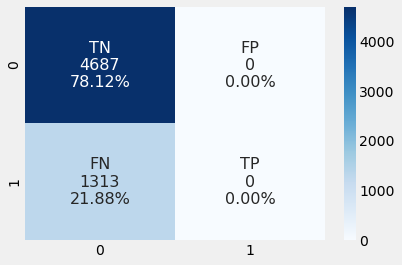

In [17]:
dc = DummyClassifier(strategy='most_frequent').fit(X_tr, y_tr)
y_pred_dc_val = dc.predict(X_val)
get_metrics_confusion(X_val, y_val, y_pred_dc_val, dc)

# Ensemble Methods

## Bagging Classifier

Instead of using a single tree, we will check if an ensemble of decsion tree can actually alleviate the issue induced by the class imbalancing. First, we will use a bagging classifier and its counter part which internally uses a random under-sampling to balanced each boostrap sample.

Balancing each bootstrap sample allows to increase significantly the balanced accuracy and the geometric mean.

Accuracy:  0.807
F1 Score:  0.44326923076923075
ROC-AUC Score:  0.740359286457933
Recall Score:  0.3511043412033511
Precision Score:  0.6010430247718384
PR-AUC Score:  0.48114820511254575

Balanced Accuracy:  0.6429086886302653
Geometric Mean:  0.5728715429649479



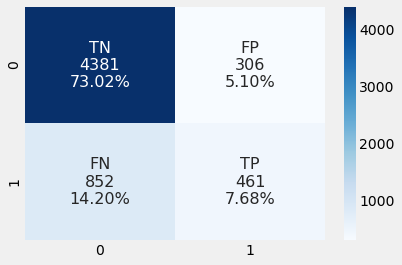

In [19]:
bc = BaggingClassifier(n_estimators=50, random_state=42).fit(X_tr_ss, y_tr)
y_pred_bc_val = bc.predict(X_val_ss)
get_metrics_confusion(X_val_ss, y_val, y_pred_bc_val, bc)
print('Balanced Accuracy: ', balanced_accuracy_score(y_val, y_pred_bc_val))
print('Geometric Mean: ', geometric_mean_score(y_val, y_pred_bc_val))
print("")

## Balanced Bagging Classifier

This implementation of Bagging is similar to the scikit-learn implementation. It includes an additional step to balance the training set at fit time using a given sampler. This classifier can serve as a basis to implement various methods such as Exactly Balanced Bagging, Roughly Balanced Bagging, Over-Bagging, or SMOTE-Bagging.

Accuracy:  0.7631666666666667
F1 Score:  0.5111799105607154
ROC-AUC Score:  0.7528188434539899
Recall Score:  0.5658796648895659
Precision Score:  0.46612296110414053
PR-AUC Score:  0.499848233823849

Balanced Accuracy:  0.6921568155896517
Geometric Mean:  0.680540328399629



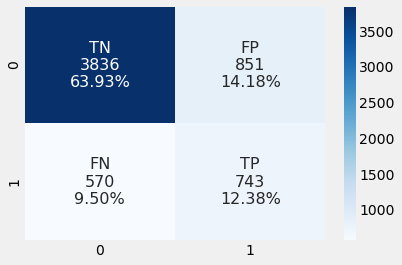

In [20]:
bbc = BalancedBaggingClassifier(n_estimators=50, random_state=42).fit(X_tr_ss, y_tr)
y_pred_bbc_val = bbc.predict(X_val_ss)
get_metrics_confusion(X_val_ss, y_val, y_pred_bbc_val, bbc)
print('Balanced Accuracy: ', balanced_accuracy_score(y_val, y_pred_bbc_val))
print('Geometric Mean: ', geometric_mean_score(y_val, y_pred_bbc_val))
print("")

## Balanced Bagging Classifier with Gradient Boosting Classifier

Accuracy:  0.7533333333333333
F1 Score:  0.5271565495207667
ROC-AUC Score:  0.7749874838134551
Recall Score:  0.6283320639756284
Precision Score:  0.45404512933406715
PR-AUC Score:  0.5372388529575939



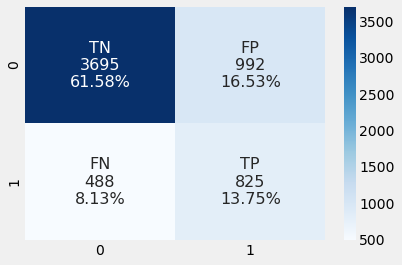

In [21]:
bbc3 = BalancedBaggingClassifier(
        base_estimator=HistGradientBoostingClassifier(random_state=42),
        n_estimators=10,
        random_state=42,
        n_jobs=2).fit(X_tr_ss, y_tr)
y_pred_bbc3_val = bbc3.predict(X_val_ss)
get_metrics_confusion(X_val_ss, y_val, y_pred_bbc3_val, bbc3)

## Balanced Random Forest Classifier

Random forest is another popular ensemble method and it is usually outperforming bagging. Here, we used a vanilla random forest and its balanced counterpart in which each bootstrap sample is balanced.

Accuracy:  0.724
F1 Score:  0.5083135391923991
ROC-AUC Score:  0.7643157793647772
Recall Score:  0.6519421172886519
Precision Score:  0.41654501216545015
PR-AUC Score:  0.5111466083509113



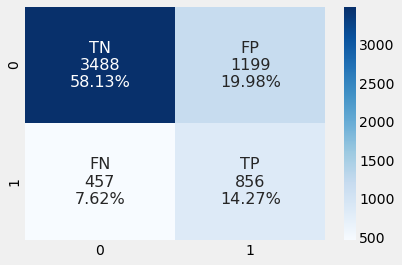

In [22]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42).fit(X_tr, y_tr)
y_pred_brf_val = brf.predict(X_val)
get_metrics_confusion(X_val, y_val, y_pred_brf_val, brf)

## RUSBoostClassifier

Random under-sampling integrated in the learning of AdaBoost.

During learning, the problem of class balancing is alleviated by random under-sampling the sample at each iteration of the boosting algorithm

Accuracy:  0.7566666666666667
F1 Score:  0.5197368421052632
ROC-AUC Score:  0.7667346817069983
Recall Score:  0.6016755521706016
Precision Score:  0.45744064852345107
PR-AUC Score:  0.5244608728332589



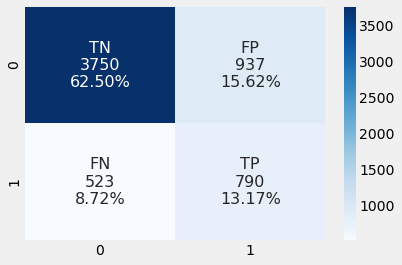

In [23]:
rbc = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R', random_state=42).fit(X_tr, y_tr)
y_pred_rbc_val = rbc.predict(X_val)
get_metrics_confusion(X_val, y_val, y_pred_rbc_val, rbc)

## Easy Ensemble Classifier

Bag of balanced boosted learners also known as EasyEnsemble.

This algorithm is known as EasyEnsemble. The classifier is an ensemble of AdaBoost learners trained on different balanced boostrap samples. The balancing is achieved by random under-sampling.

Accuracy:  0.7516666666666667
F1 Score:  0.5278833967046895
ROC-AUC Score:  0.7749849651391096
Recall Score:  0.6344249809596344
Precision Score:  0.45198046663049374
PR-AUC Score:  0.5262955379856071



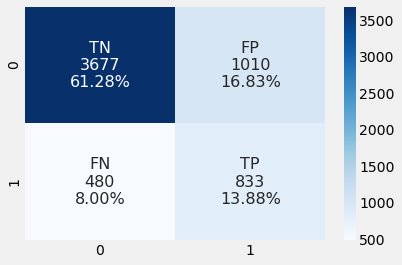

In [24]:
eec = EasyEnsembleClassifier(random_state=42).fit(X_tr, y_tr) 
y_pred_eec_val = eec.predict(X_val)
get_metrics_confusion(X_val, y_val, y_pred_eec_val, eec)

# Undersampling Methods

## Tomek Links

Tomek links are instances of a minority-majority class pair where each is its own nearest neighbor aka instances of opposing class very close together.  These pairs ultimately fall into one of two categories:  boundary or noise instances.  Only these two cases will have nearest neighbors from opposite classes.  By identifying such pairs, Tomek links removes the majority instance with the goal of clarifying the boundary between the two classes by making the minority class region more distinct.

Training Count:  Counter({0: 14764, 1: 4656})
Accuracy:  0.8201666666666667
F1 Score:  0.49079754601226994
ROC-AUC Score:  0.7802667877363634
Recall Score:  0.39603960396039606
Precision Score:  0.6451612903225806
PR-AUC Score:  0.543071298221949



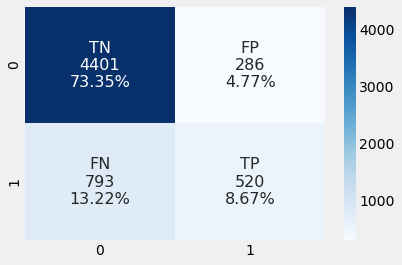

In [27]:
tl = TomekLinks()
run_resampling(X_tr, y_tr, X_val, y_val, tl, rfcb)

In [28]:
X_tr_tl, y_tr_tl = tl.fit_resample(X_tr, y_tr)
tlm = .fit(X_tr_tl, y_tr_tl)
y_pred_tl_val = tlm.predict(X_val)

## Edited Nearest Neighbors Rule

This is a rule for finding ambiguous and noisy examples in the dataset by using k = 3 nearest neighbors to edit the preclassified samples and then k = 1 rule to make decisions.



Training Count:  Counter({0: 9976, 1: 4656})
Accuracy:  0.7858333333333334
F1 Score:  0.5263545890158496
ROC-AUC Score:  0.7784206806888038
Recall Score:  0.5437928408225438
Precision Score:  0.51
PR-AUC Score:  0.5339881023136849



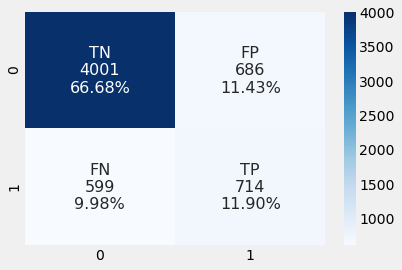

In [29]:
enn = EditedNearestNeighbours()
run_resampling(X_tr, y_tr, X_val, y_val, enn, rfcb)

In [30]:
X_tr_enn, y_tr_enn = enn.fit_resample(X_tr, y_tr)
ennm = enn.fit(X_tr_enn, y_tr_enn)
y_pred_enn_val = ennm.predict(X_val)

## One Sided Selection

Training Count:  Counter({0: 13357, 1: 4656})
Accuracy:  0.8188333333333333
F1 Score:  0.48943165805542493
ROC-AUC Score:  0.7789437524770351
Recall Score:  0.3968012185833968
Precision Score:  0.6384803921568627
PR-AUC Score:  0.5418102917511061



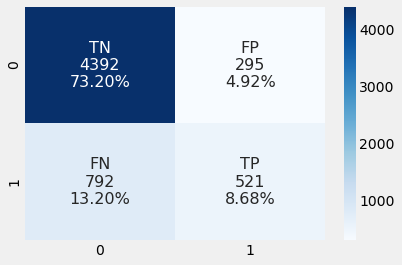

In [31]:
oss = OneSidedSelection(n_neighbors=1, n_seeds_S=200)
run_resampling(X_tr, y_tr, X_val, y_val, oss, rfcb)

In [32]:
X_tr_oss, y_tr_oss = oss.fit_resample(X_tr, y_tr)
ossm = rfcb.fit(X_tr_oss, y_tr_oss)
y_pred_oss_val = ossm.predict(X_val)

## Neighborhood Cleaning Rule

Training Count:  Counter({0: 10206, 1: 4656})
Accuracy:  0.79
F1 Score:  0.5294996265870051
ROC-AUC Score:  0.7781037339590913
Recall Score:  0.53998476770754
Precision Score:  0.5194139194139195
PR-AUC Score:  0.5306085472044293



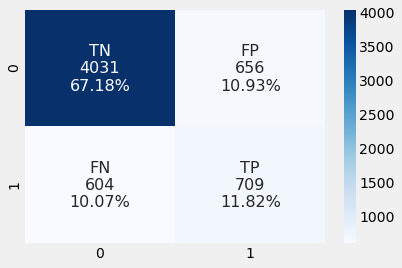

In [33]:
ncr = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)
run_resampling(X_tr, y_tr, X_val, y_val, ncr, rfcb)

In [34]:
X_tr_ncr, y_tr_ncr = ncr.fit_resample(X_tr, y_tr)
ncrm = rfcb.fit(X_tr_ncr, y_tr_ncr)
y_pred_ncr_val = ncrm.predict(X_val)

# Oversampling Methods

## SMOTE

Training Count:  Counter({0: 16344, 1: 16344})
Accuracy:  0.7611666666666667
F1 Score:  0.5212161710658202
ROC-AUC Score:  0.7731917502528018
Recall Score:  0.594059405940594
Precision Score:  0.4642857142857143
PR-AUC Score:  0.5348555024642285



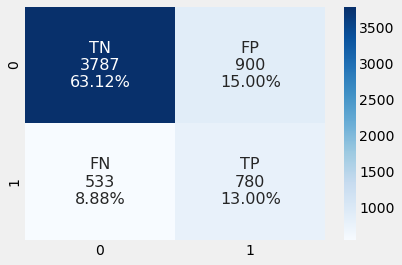

In [35]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
run_resampling(X_tr, y_tr, X_val, y_val, sm, rfcb)

In [36]:
X_tr_sm, y_tr_sm = sm.fit_resample(X_tr, y_tr)
smm = rfcb.fit(X_tr_sm, y_tr_sm)
y_pred_sm_val = smm.predict(X_val)

## SVMSMOTE

Training Count:  Counter({0: 16344, 1: 16344})
Accuracy:  0.7658333333333334
F1 Score:  0.5305713331105913
ROC-AUC Score:  0.774958640929823
Recall Score:  0.6047220106626047
Precision Score:  0.4726190476190476
PR-AUC Score:  0.5336303119189262



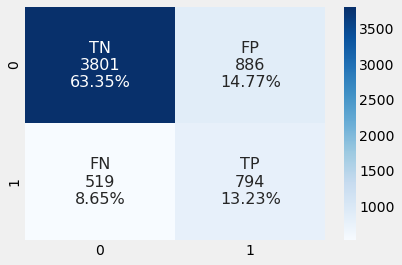

In [37]:
svmsm = SVMSMOTE()
run_resampling(X_tr, y_tr, X_val, y_val, svmsm, rfcb)

In [38]:
X_tr_svm, y_tr_svm = svmsm.fit_resample(X_tr, y_tr)
svmsmote = rfcb.fit(X_tr_svm, y_tr_svm)
y_pred_svmsm_val = svmsmote.predict(X_val)

## ADASYN

Training Count:  Counter({0: 16344, 1: 15798})
Accuracy:  0.74
F1 Score:  0.514321295143213
ROC-AUC Score:  0.7696475692111397
Recall Score:  0.6290936785986291
Precision Score:  0.43496577145866244
PR-AUC Score:  0.5327081474838515



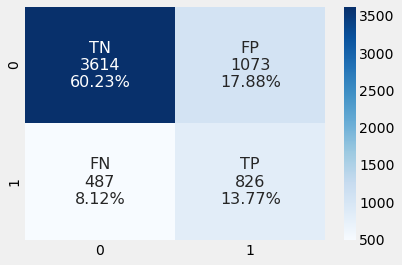

In [39]:
adsn = ADASYN()
run_resampling(X_tr, y_tr, X_val, y_val, adsn, rfcb)

In [40]:
X_tr_adsn, y_tr_adsn = adsn.fit_resample(X_tr, y_tr)
adsnm = rfcb.fit(X_tr_adsn, y_tr_adsn)
y_pred_adsnm_val = adsnm.predict(X_val)

# Combined Methods

## SMOTE Tomek

Training Count:  Counter({0: 15438, 1: 15438})
Accuracy:  0.7613333333333333
F1 Score:  0.5229846768820786
ROC-AUC Score:  0.772028691438181
Recall Score:  0.5978674790555979
Precision Score:  0.46477205447010067
PR-AUC Score:  0.5354585785863792



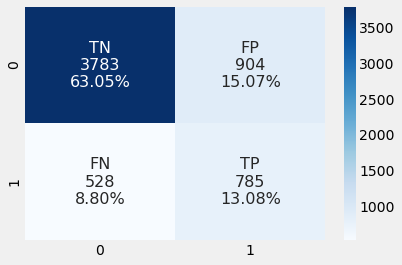

In [41]:
smtk = SMOTETomek()
run_resampling(X_tr, y_tr, X_val, y_val, smtk, rfcb)

In [42]:
X_tr_smt, y_tr_smt = smtk.fit_resample(X_tr, y_tr)
smtkm = rfcb.fit(X_tr_smt, y_tr_smt)
y_pred_smtk_val = smtkm.predict(X_val)

## SMOTE ENN

Training Count:  Counter({1: 10850, 0: 8551})
Accuracy:  0.7261666666666666
F1 Score:  0.5128965312777942
ROC-AUC Score:  0.7739785516192557
Recall Score:  0.6587966488956588
Precision Score:  0.4199029126213592
PR-AUC Score:  0.5275792224261011



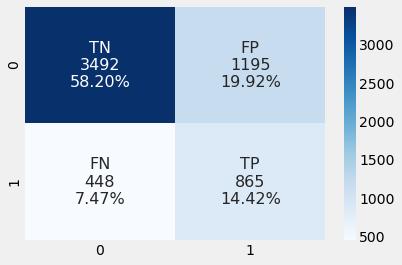

In [43]:
smenn = SMOTEENN(sampling_strategy="minority", n_jobs= -1)
run_resampling(X_tr, y_tr, X_val, y_val, smenn, rfcb)

In [44]:
X_tr_sme, y_tr_sme = smenn.fit_resample(X_tr, y_tr)
smennm = rfcb.fit(X_tr_sme, y_tr_sme)
y_pred_smenn_val = smennm.predict(X_val)

# SMOTE Variants

Training Count:  Counter({1: 18624, 0: 16344})
Accuracy:  0.8216666666666667
F1 Score:  0.4723865877712031
ROC-AUC Score:  0.7800361259148678
Recall Score:  0.3648134044173648
Precision Score:  0.66993006993007
PR-AUC Score:  0.5450342231926433



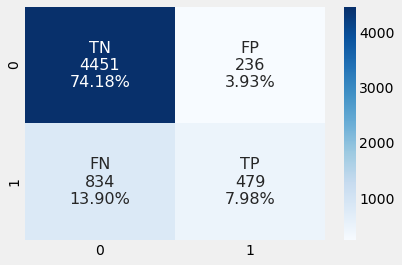

In [46]:
pfsm = sv.polynom_fit_SMOTE()
run_resampling_2(X_tr, y_tr, X_val, y_val, pfsm, rfcb)

In [47]:
X_tr_pfs, y_tr_pfs = pfsm.sample(X_tr, y_tr)
pfsmm = rfcb.fit(X_tr_pfs, y_tr_pfs)
y_pred_pfsm_val = pfsmm.predict(X_val)

Training Count:  Counter({0: 16344, 1: 16344})
Accuracy:  0.814
F1 Score:  0.4871323529411764
ROC-AUC Score:  0.7706653573893274
Recall Score:  0.4036557501904037
Precision Score:  0.6141367323290846
PR-AUC Score:  0.5366600017060352



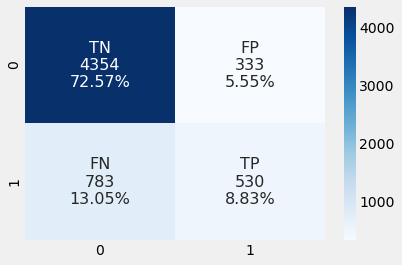

In [48]:
pws = sv.ProWSyn()
run_resampling_2(X_tr, y_tr, X_val, y_val, pws, rfcb)

In [49]:
X_tr_pws, y_tr_pws = pws.sample(X_tr, y_tr)
pwsm = rfcb.fit(X_tr_pws, y_tr_pws)
y_pred_pws_val = pwsm.predict(X_val)

Training Count:  Counter({0: 16335, 1: 16309})
Accuracy:  0.7641666666666667
F1 Score:  0.5265975242556039
ROC-AUC Score:  0.773998944756697
Recall Score:  0.5993907083015994
Precision Score:  0.46957040572792363
PR-AUC Score:  0.5353553531585872



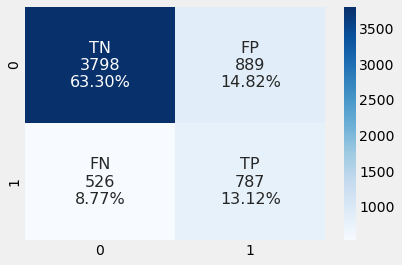

In [50]:
smipf = sv.SMOTE_IPF()
run_resampling_2(X_tr, y_tr, X_val, y_val, smipf, rfcb)

In [51]:
X_tr_smi, y_tr_smi = smipf.sample(X_tr, y_tr)
smipfm = rfcb.fit(X_tr_smi, y_tr_smi)
y_pred_smipf_val = smipfm.predict(X_val)

Training Count:  Counter({0: 16344, 1: 16344})
Accuracy:  0.755
F1 Score:  0.522106631989597
ROC-AUC Score:  0.7749020926283926
Recall Score:  0.6115765422696116
Precision Score:  0.4554736245036869
PR-AUC Score:  0.5369155058677939



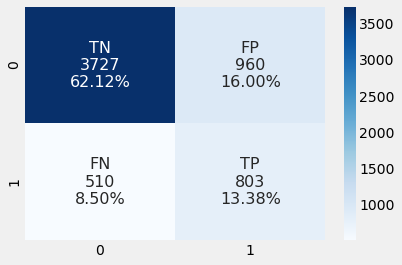

In [52]:
smobd = sv.SMOBD()
run_resampling_2(X_tr, y_tr, X_val, y_val, smobd, rfcb)

In [53]:
X_tr_smo, y_tr_smo = smobd.sample(X_tr, y_tr)
smobdm = rfcb.fit(X_tr_smo, y_tr_smo)
y_pred_smobd_val = smobdm.predict(X_val)

Training Count:  Counter({0: 16344, 1: 16344})
Accuracy:  0.763
F1 Score:  0.5159972770592239
ROC-AUC Score:  0.7728078555340394
Recall Score:  0.5773038842345773
Precision Score:  0.4664615384615385
PR-AUC Score:  0.535964889812004



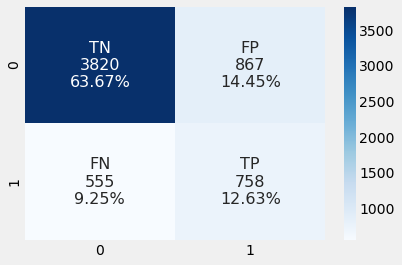

In [54]:
gsm = sv.G_SMOTE()
run_resampling_2(X_tr, y_tr, X_val, y_val, gsm, rfcb)

In [55]:
X_tr_gsm, y_tr_gsm = gsm.sample(X_tr, y_tr)
gsmm = rfcb.fit(X_tr_gsm, y_tr_gsm)
y_pred_gsm_val = gsmm.predict(X_val)

Training Count:  Counter({0: 16344, 1: 16326})
Accuracy:  0.8208333333333333
F1 Score:  0.4707040866568193
ROC-AUC Score:  0.7715774424925711
Recall Score:  0.36405178979436403
Precision Score:  0.6657381615598886
PR-AUC Score:  0.5351789456875755



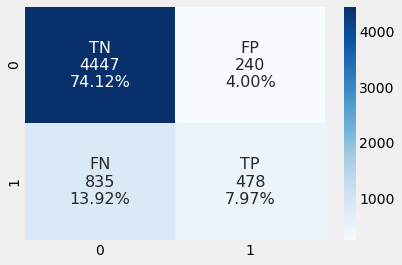

In [56]:
ccr = sv.CCR()
run_resampling_2(X_tr, y_tr, X_val, y_val, ccr, rfcb)

In [57]:
X_tr_ccr, y_tr_ccr = ccr.sample(X_tr, y_tr)
ccrm = rfcb.fit(X_tr_ccr, y_tr_ccr)
y_pred_ccr_val = ccrm.predict(X_val)

Training Count:  Counter({0: 16344, 1: 16344})
Accuracy:  0.8158333333333333
F1 Score:  0.4715447154471545
ROC-AUC Score:  0.7666850394481276
Recall Score:  0.37547600913937546
Precision Score:  0.6336760925449871
PR-AUC Score:  0.5246416523041935



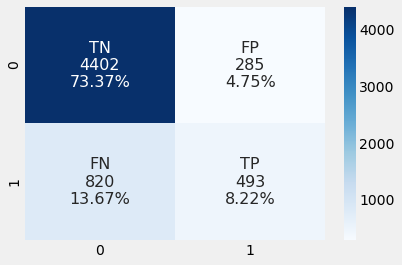

In [58]:
lvq = sv.LVQ_SMOTE()
run_resampling_2(X_tr, y_tr, X_val, y_val, lvq, rfcb)

In [59]:
X_tr_lvq, y_tr_lvq = lvq.sample(X_tr, y_tr)
lvqm = rfcb.fit(X_tr_lvq, y_tr_lvq)
y_pred_lvq_val = lvqm.predict(X_val)

Training Count:  Counter({0: 16344, 1: 16344})
Accuracy:  0.762
F1 Score:  0.5204835460040296
ROC-AUC Score:  0.7733676512191765
Recall Score:  0.5902513328255903
Precision Score:  0.46546546546546547
PR-AUC Score:  0.534306565068462



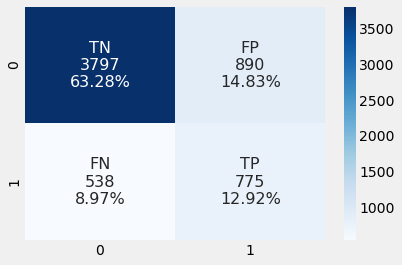

In [60]:
ass = sv.Assembled_SMOTE()
run_resampling_2(X_tr, y_tr, X_val, y_val, ass, rfcb)

In [61]:
X_tr_ass, y_tr_ass = ass.sample(X_tr, y_tr)
assm = rfcb.fit(X_tr_ass, y_tr_ass)
y_pred_ass_val = assm.predict(X_val)

In [62]:
data = {'Accuracy': ["",
                     accuracy(y_val, y_pred_bc_val),
                     accuracy(y_val, y_pred_bbc_val),
                     accuracy(y_val, y_pred_bbc3_val),
                     accuracy(y_val, y_pred_brf_val),
                     accuracy(y_val, y_pred_rbc_val),
                     accuracy(y_val, y_pred_eec_val),
                     "",
                     accuracy(y_val, y_pred_tl_val),
                     accuracy(y_val, y_pred_enn_val),
                     accuracy(y_val, y_pred_oss_val),
                     accuracy(y_val, y_pred_ncr_val),
                     "",
                     accuracy(y_val, y_pred_sm_val),
                     accuracy(y_val, y_pred_svmsm_val),
                     accuracy(y_val, y_pred_adsnm_val),
                     "",
                     accuracy(y_val, y_pred_smtk_val),
                     accuracy(y_val, y_pred_smenn_val),
                     "",
                     accuracy(y_val, y_pred_pfsm_val),
                     accuracy(y_val, y_pred_pws_val),
                     accuracy(y_val, y_pred_smipf_val),
                     accuracy(y_val, y_pred_smobd_val),
                     accuracy(y_val, y_pred_gsm_val),
                     accuracy(y_val, y_pred_ccr_val),
                     accuracy(y_val, y_pred_lvq_val),
                     accuracy(y_val, y_pred_ass_val)],
    'F1 Score': ["",
                f1_score(y_val, y_pred_bc_val),
                f1_score(y_val, y_pred_bbc_val),
                f1_score(y_val, y_pred_bbc3_val),
                f1_score(y_val, y_pred_brf_val),
                f1_score(y_val, y_pred_rbc_val),
                f1_score(y_val, y_pred_eec_val),
                "",
                f1_score(y_val, y_pred_tl_val),
                f1_score(y_val, y_pred_enn_val),
                f1_score(y_val, y_pred_oss_val),
                f1_score(y_val, y_pred_ncr_val),
                "",
                f1_score(y_val, y_pred_sm_val),
                f1_score(y_val, y_pred_svmsm_val),
                f1_score(y_val, y_pred_adsnm_val),
                "",
                f1_score(y_val, y_pred_smtk_val),
                f1_score(y_val, y_pred_smenn_val),
                "",
                f1_score(y_val, y_pred_pfsm_val),
                f1_score(y_val, y_pred_pws_val),
                f1_score(y_val, y_pred_smipf_val),
                f1_score(y_val, y_pred_smobd_val),
                f1_score(y_val, y_pred_gsm_val),
                f1_score(y_val, y_pred_ccr_val),
                f1_score(y_val, y_pred_lvq_val),
                f1_score(y_val, y_pred_ass_val)],
    'PR AUC Score': ["",
              aps(X_val, y_val, bc),
              aps(X_val, y_val, bbc),
              aps(X_val, y_val, bbc3),
              aps(X_val, y_val, brf),
              aps(X_val, y_val, rbc),
              aps(X_val, y_val, eec),
              "",
              aps(X_val, y_val, tlm),
              aps(X_val, y_val, ennm),
              "",
              "",
              "",
              aps(X_val, y_val, smm),
              aps(X_val, y_val, svmsmote),
              aps(X_val, y_val, adsnm),
              "",
              aps(X_val, y_val, smtkm),
              aps(X_val, y_val, smennm),
              "",
              aps(X_val, y_val, pfsmm),
              aps(X_val, y_val, pwsm),
              aps(X_val, y_val, smipfm),
              aps(X_val, y_val, smobdm),
              aps(X_val, y_val, gsmm),
              aps(X_val, y_val, ccrm),
              aps(X_val, y_val, lvqm),
              aps(X_val, y_val, assm)],
            'ROC AUC Score': ["",
              auc(y_val, y_bc),
              auc(X_val, y_val, bbc),
              auc(X_val, y_val, bbc3),
              auc(X_val, y_val, brf),
              auc(X_val, y_val, rbc),
              auc(X_val, y_val, eec),
              "",
              auc(X_val, y_val, tlm),
              auc(X_val, y_val, ennm),
              "",
              "",
              "",
              auc(X_val, y_val, smm),
              auc(X_val, y_val, svmsmote),
              auc(X_val, y_val, adsnm),
              "",
              auc(X_val, y_val, smtkm),
              auc(X_val, y_val, smennm),
              "",
              auc(X_val, y_val, pfsmm),
              auc(X_val, y_val, pwsm),
              auc(X_val, y_val, smipfm),
              auc(X_val, y_val, smobdm),
              auc(X_val, y_val, gsmm),
              auc(X_val, y_val, ccrm),
              auc(X_val, y_val, lvqm),
              auc(X_val, y_val, assm)]}
scores = pd.DataFrame(data=data, index = ['ENSEMBLE METHODS',
                                          'BaggingClassifier',
                                          'BalancedBaggingClassifier',
                                          'BBC with GradientBoostingClassifier',
                                          'BalancedRandomForestClassifier',
                                          'RUBoostClassifier',
                                          'EasyEnsembleClassifier',
                                          'UNDERSAMPLING METHODS',
                                          'TomekLinks',
                                          'EditedNearestNeighbours',
                                          'OneSidedSelection',
                                          'NeighbourhoodCleaningRule',
                                          'OVERSAMPLING METHODS',
                                          'SMOTE',
                                          'SVMSMOTE',
                                          'ADASYN',
                                          'COMBINED METHODS',
                                          'SMOTETomek',
                                          'SMOTEENN',
                                          'SMOTE-VARIANTS',
                                          'sv.polynom_fit_SMOTE',
                                          'sv.ProWSyn',
                                          'sv.SMOTE_IPF',
                                          'sv.SMOBD',
                                          'sv.G_SMOTE',
                                          'sv.CCR',
                                          'sv.LQV_SMOTE',
                                          'sv.Assembled_SMOTE'])

TypeError: auc() takes 2 positional arguments but 3 were given

In [60]:
scores

,Accuracy,F1 Score,PR AUC Score
ENSEMBLE METHODS,,,
BaggingClassifier,0.807,0.443269,0.204693
BalancedBaggingClassifier,0.763167,0.51118,0.307574
BBC with GradientBoostingClassifier,0.753333,0.527157,0.43927
BalancedRandomForestClassifier,0.724,0.508314,0.511147
RUBoostClassifier,0.756667,0.519737,0.524461
EasyEnsembleClassifier,0.751667,0.527883,0.526296
UNDERSAMPLING METHODS,,,
TomekLinks,0.819667,0.489623,0.535317
EditedNearestNeighbours,0.786667,0.527326,0.535317
